# Using a radial basis function network to predict $K_{\mathrm{c}}$ for the $\infty$-state clock (XY) model

In the paper, we showed the result of fitting a radial basis function network to the helicity modulus $\Upsilon(K,N_{\mathrm{s}})$ for the $\infty$-state clock (XY) model at fixed $N_{\mathrm{s}}=128,160,256,320,512$. In this notebook, we're going to use that fit to predict the pseudocritical temperature $K_{\mathrm{c}}(N_{\mathrm{s}})$ from the universal jump condition

$$\Upsilon(K_{\mathrm{c}},N_{\mathrm{s}})=2f_{r}/\pi K_{\mathrm{c}}(N_{\mathrm{s}}).$$

From $K_{\mathrm{c}}(N_{\mathrm{s}})$, we will extract $K_{\mathrm{c}}$ by extrapolating $K_{\mathrm{c}}(N_{\mathrm{s}})$ to $1/N_{\mathrm{s}} \rightarrow 0$ using

$$K_{\mathrm{c}}(N_{\mathrm{s}})=K_{\mathrm{c}}+\zeta^{-1/\nu}\log\big(\kappa N_{\mathrm{s}}\big)^{-1/\nu}.$$

Unfortunately, our data is not precise enough to determine both $K_{\mathrm{c}}$ and $\nu$, so we settle for $K_{\mathrm{c}}$ and set $\nu$ to its exact value $\nu=1/2$. In this notebook, we're going to focus on extracting information from a radial basis function network that has already been fit to data. First, let's load up some modules.

In [1]:
""" External modules """
import gvar as gv # Peter Lepage's GVar module
import numpy as np # NumPy for number crunching

""" Local modules """
import example_tools # For getting example data

""" SwissFit modules """
from swissfit import fit # SwissFit fitter module
from swissfit.machine_learning import radial_basis # Module for radial basis function network
from swissfit.optimizers import scipy_least_squares # Trust region reflective local optimizer
from swissfit.optimizers import scipy_basin_hopping # Basin hopping global optimizer
from swissfit.empirical_bayes import single_parameter_surrogate # Empirical Bayes optimizer

Now, let's set up the radial basis function network

In [2]:
# Define network topology
network_topology = {
    'lyr1': { # Hidden layer
        'in': 1, 'out': 2, # Dimension of input & output
        'activation': 'exp', # Exponential activation
    },
    'lyr2': { # Output layer
        'in': 2, 'out': 1,
        'activation': 'linear' # Linear activation
    }
}

# Create neural network
neural_network = radial_basis.RadialBasisNeuralNetwork(network_topology)

Next, let's grab both the data for the helicity modulus and the interpolations.

In [3]:
# Grab interpolations
interpolations = example_tools.clockinf_interp(['128', '160', '256', '320', '512'])

# Grab data
data = example_tools.clockinf_interp_data(['128', '160', '256', '320', '512'])

Now let's get our estimate for $\Upsilon(K,N_{\mathrm{s}})$ and extract from it $K_{\mathrm{c}}(N_{\mathrm{s}})$. While we're at it, we'll also compare the interpolation against our data by plotting it.

Text(0, 0.5, '$\\Upsilon(K,N_{\\mathrm{s}})$')

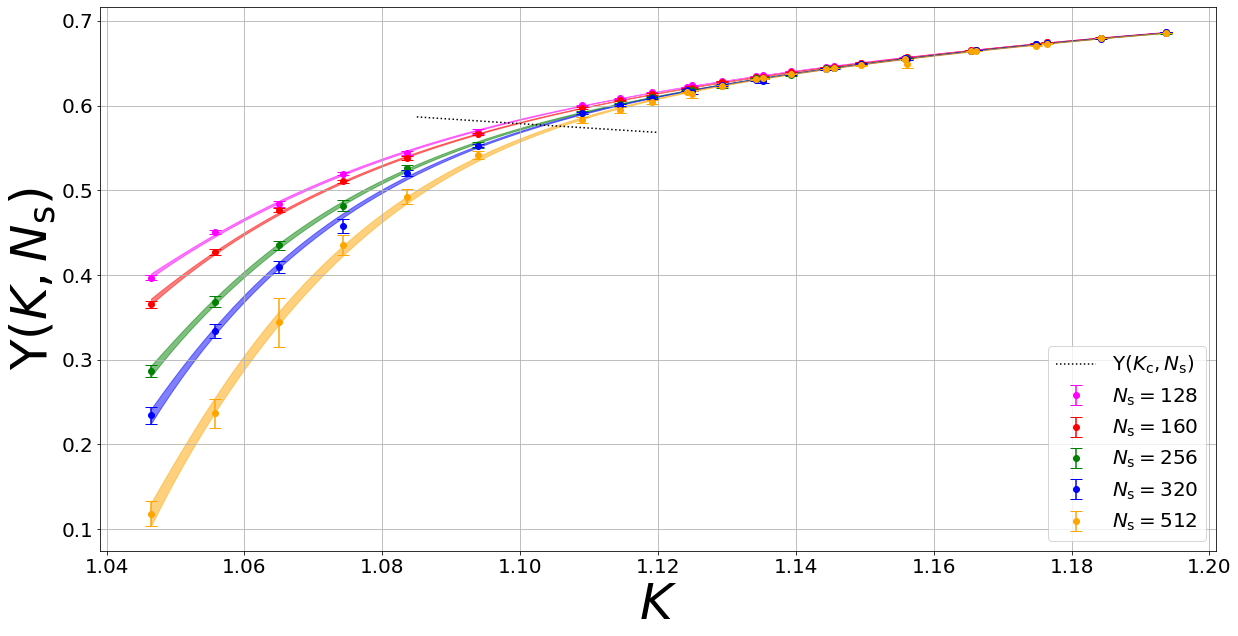

In [4]:
""" Get plotting set up """
# Import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.close()

# Set figure information up
colors = {
    '128': 'magenta', '160': 'red', '256': 'green', 
    '320': 'blue', '512': 'orange'
}

# Values of K over which the heat capacity will be plotted
Kl, Kh = 1. / 1.17, 1. / 1.1
Ks = np.linspace(Kl, Kh, 100)

""" Set extraction of K_{c}(N_s) up """
# Universal jump condition
fr = 1 - 16. * np.exp(-4. * np.pi) 
Yc = lambda K: 2. * fr / K / np.pi

# Lower and upper bound on K
Kl, Kh = 1.09, 1.12

# Dictionary to save roots (*said in the voice of Max Cavalera*)
roots = {}

""" Plot data and get K_c(N_s) """
# Plot each volume
for vol in interpolations.keys():
    """ Get interpolation """
    # Define interpolation function
    Y = lambda K: np.ravel(neural_network.out(K, interpolations[vol]))

    """ Plot data """
    # Get flattened x values
    x_flat = np.array(data[vol]['x']).flatten()
    
    # Plot as errorbar
    plt.errorbar(
        x_flat, gv.mean(data[vol]['y']), gv.sdev(data[vol]['y']),
        capsize = 6., fmt = 'o', color = colors[vol],
        label = '$N_{\mathrm{s}}=' + vol + '$'
    )

    """ Plot interpolation """
    # Get x_flat for interpolation
    x_flat = np.linspace(x_flat[0], x_flat[-1], 100).reshape( (1, 100) )
    
    # Get interpolation
    Y_interp = Y(*x_flat)

    # Plot interpolation
    plt.fill_between(
        x_flat.flatten(),
        gv.mean(Y_interp) - gv.sdev(Y_interp),
        gv.mean(Y_interp) + gv.sdev(Y_interp),
        alpha = 0.5, color = colors[vol],
    ) # Fill-between plot

    """ Extract K_{c}(N_{s}) """
    # Difference between interpolation & universal jump condition
    Y_diff = lambda x: Y([[x]])[0] - Yc(x)

    # Calculate K_{s}(N_{s}) as root of difference
    roots[float(vol)] = gv.root.refine(Y_diff, [Kl, Kh])

""" Plot universal jump condition """
x_low, x_high = 1.085, 1.12
xvs = np.linspace(x_low, x_high, 100)
plt.plot(
    xvs, [*map(Yc, xvs)], color = 'k', 
    linestyle = 'dotted', 
    label = '$\\Upsilon(K_{\mathrm{c}},N_{\mathrm{s}})$'
)

""" Finish figure up """
plt.grid('on')
plt.legend(fontsize = 20.)
plt.gca().xaxis.set_tick_params(labelsize = 20.)
plt.gca().yaxis.set_tick_params(labelsize = 20.)
plt.xlabel('$K$', fontsize = 50.)
plt.ylabel('$\\Upsilon(K,N_{\mathrm{s}})$', fontsize = 50.)

Now that we've extracted $K_{\mathrm{c}}(N_{\mathrm{s}})$ from our RBFN-based fit to the helicity modulus, let's use SwissFit to extrapolate $K_{\mathrm{c}}(K_{\mathrm{s}})$ to $1/N_{\mathrm{s}} \rightarrow 0$ using 
$$K_{\mathrm{c}}(N_{\mathrm{s}})=K_{\mathrm{c}}+\zeta^{-1/\nu}\log\big(\kappa N_{\mathrm{s}}\big)^{-1/\nu}.$$
We will use the surrogate-based empirical Bayes procedure discussed in the paper to estimate the prior on $\kappa$.

In [5]:
""" Set up data and fit function """
# Get data
fit_data = {}
fit_data['x'], fit_data['y'] = np.transpose([[1. / gv.log(Ns), 1. / K] for Ns, K in roots.items()])
fit_data['x'] = fit_data['x'].reshape( (len(fit_data['x']),1) )

# Define fit function
def fit_fcn(x, p):
    return p['tc'][0] + p['zeta_power'][0] * x**2. / (1. + p['logkappa'][0] * x)**2.

""" Define function to do the fit at different values of kappa """
# This function does the fit at a particlar value for the kappa prior
def do_fit(zeta_power_width, return_fit = False):
    # Step 1.) Create SwissFit fitter
    fitter = fit.SwissFit(
        udata = fit_data,
        uprior = {'zeta_power': [gv.gvar(0., zeta_power_width)]},
        fit_fcn = fit_fcn,
        p0 = {'tc': [0.89], 'logkappa': [0.5], 'zeta_power': [0.5]}
    )

    # Step 2.) Create local optimizer
    local_optimizer = scipy_least_squares.SciPyLeastSquares(fitter = fitter)
        
    # Step 3.) Do fit
    fitter(local_optimizer)

    # Return negative value of log of marginal likelihood
    if return_fit: return fitter
    else: return -fitter.logml

""" Set up empirical Bayes analysis """
# Create empirical Bayes object
emp_bayes_fit = single_parameter_surrogate.SingleParameterSurrogate(
    fcn = do_fit, # Our "do_fit" function that does the fit & calculates the marginal likelihood
    lb = 1., ub = 7.5, # Lower & upper bound on kappa_width
    n_points = 20, # Number of fits to perform
    spline_algorithm = 'steffen', # Use a monotonic spline
)

# Do empirical Bayes analysis
zeta_power_width_star = emp_bayes_fit().x[0]

# Fit data at lambda^{*} from empirical Bayes
fit_result = do_fit(zeta_power_width_star, return_fit = True)

# Print result of the fit
print(fit_result)

# Save fit parameters
fit_parameters = fit_result.p


SwissFit: ðŸ§€
   chi2/dof [dof] = 0.11 [3]   Q = 0.95   (Bayes) 
   chi2/dof [dof] = 0.12 [2]   Q = 0.89   (freq.) 
   AIC [k] = 6.24 [3]   logML = 27.243*

Parameters*:
     tc
             1                  0.890(11)   [n/a]
     logkappa
             1                   2.6(4.8)   [n/a]
     zeta_power
             1                   1.2(2.1)   [0.0(3.7)]

Estimator:
   SwissFit optimizer object
*Laplace approximation



Just for fun, let's see what the marginal likelihood looked like for this empirical Bayes analysis

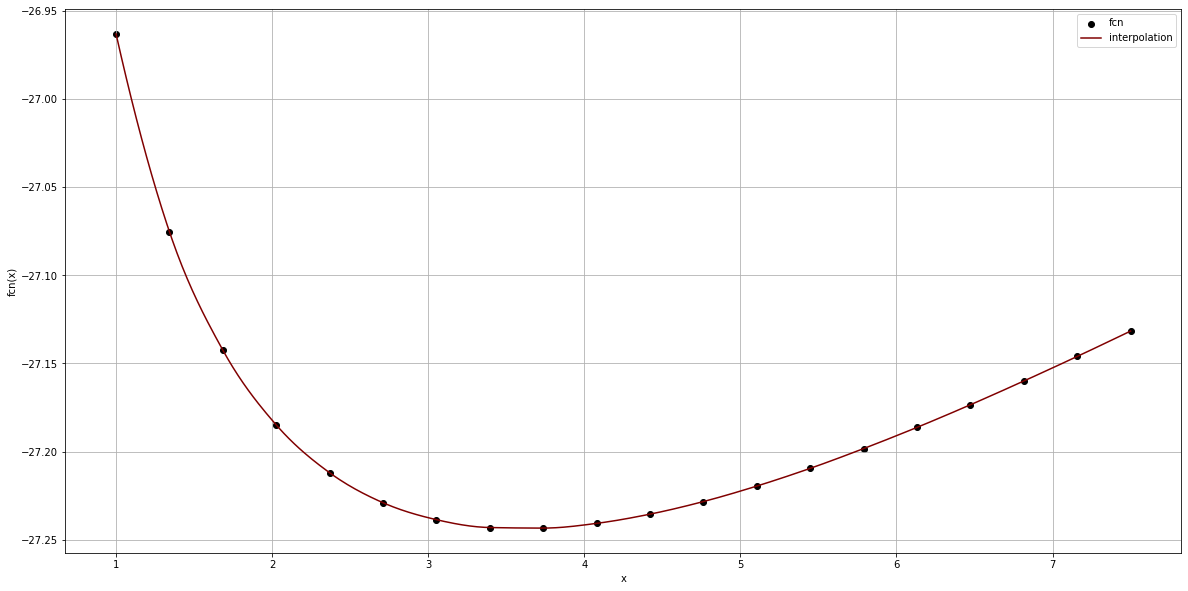

In [6]:
emp_bayes_fit.visualize_sample_points()